# Power Curves

[![Binder](https://notebooks.gesis.org/binder/badge_logo.svg)](https://notebooks.gesis.org/binder/v2/gh/AyrtonB/Merit-Order-Effect/main?filepath=nbs%2Fug-03-power-curve.ipynb)

In this notebook we'll look at how we can use our LOWESS methods to first fit a power curve for a wind turbine, then estimate the uncertainty in our results. We'll then utilise a feature of the quantile LOWESS fits to demonstrate how these techniques can also be used for cleaning raw turbine data.

<br>

### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from moepy import lowess, eda

<br>

### Power Curve Fitting

We'll start by loading in some clean turbine output and wind speed data, this was sourced from the [Power Curve Working Group Analysis](https://github.com/PCWG/PCWG) example data repository.

In [2]:
df_pcwga = (pd
            .read_csv('../data/lowess_examples/turbine_power_wind_speed_clean.csv')
            [['TimeStamp', 'Turbine Wind Speed Mean', 'Turbine Power']]
            .replace(-99.99, np.nan)
            .dropna()
           )

df_pcwga.head()

,TimeStamp,Turbine Wind Speed Mean,Turbine Power
0,07/10/2011 12:50,15.510002,1996.910019
1,07/10/2011 13:00,15.710131,1987.739944
2,07/10/2011 13:10,16.670750,1991.900040
3,07/10/2011 13:20,15.209808,1987.700012
4,07/10/2011 13:30,15.439957,1991.030045


<br>

We'll then fit a standard LOWESS and visualise the results

Wall time: 512 ms


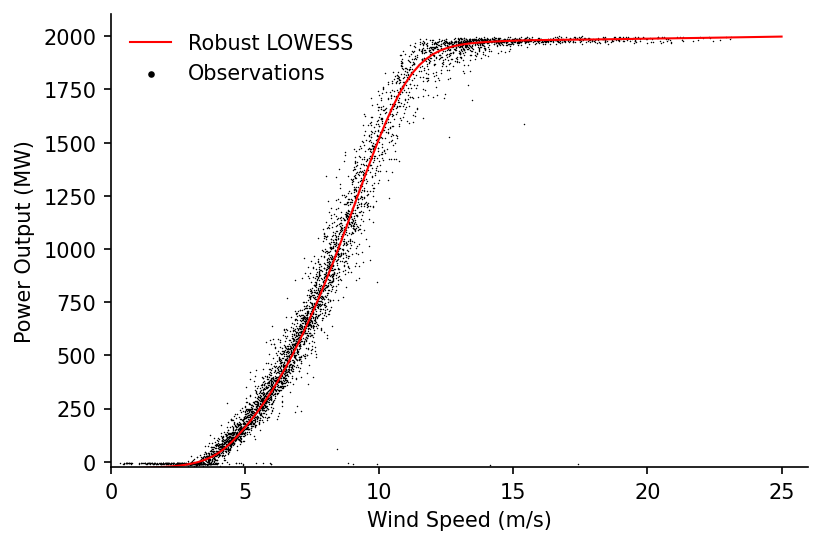

In [3]:
%%time

x = df_pcwga['Turbine Wind Speed Mean'].values
y = df_pcwga['Turbine Power'].values

lowess_model = lowess.Lowess()
lowess_model.fit(x, y, frac=0.2, num_fits=100)

x_pred = np.linspace(0, 25, 101)
y_pred = lowess_model.predict(x_pred)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.plot(x_pred, y_pred, label='Robust LOWESS', color='r', linewidth=1)
ax.scatter(x, y, label='Observations', s=0.5, color='k', linewidth=0, alpha=1)

eda.hide_spines(ax)
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Power Output (MW)')
ax.set_xlim(0, 26)
ax.set_ylim(-25)

lgnd = ax.legend(frameon=False) 
lgnd.legendHandles[1]._sizes = [10]
lgnd.legendHandles[1].set_alpha(1)

<br>

This looks good but we can do more. In this next step we'll estimate the upper and lower quantiles of the power curve fit that represent a prediction interval of 68%.

In [4]:
# Estimating the quantiles
df_quantiles = lowess.quantile_model(x, y, frac=0.2, qs=[0.16, 0.84], num_fits=40)

# Cleaning names and sorting for plotting
df_quantiles.columns = [f'p{int(col*100)}' for col in df_quantiles.columns]
df_quantiles = df_quantiles[df_quantiles.columns[::-1]]

df_quantiles.head()

 [████████████████████████████████████████████████████████████] 2/2 [00:06<00:03, 3.19s/it]

,p84,p16
x,,
0.323938,-16.256912,-8.347957
0.463498,-14.471922,-8.538979
0.475784,-14.315327,-8.556336
0.503802,-13.957291,-8.596028
0.546645,-13.405900,-8.656773


<br>

We'll visualise this fit within the domain where the quantiles do not cross

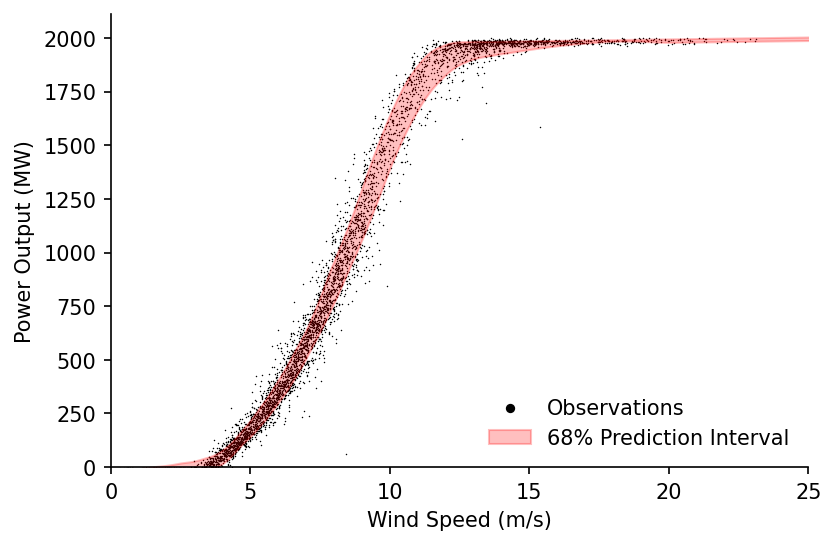

In [5]:
valid_pred_intvl_idx = (df_quantiles['p84']-df_quantiles['p16']).pipe(lambda s: s[s>0]).index

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(x, y, s=0.5, color='k', linewidth=0, alpha=1, label='Observations')
ax.fill_between(valid_pred_intvl_idx, df_quantiles.loc[valid_pred_intvl_idx, 'p16'], df_quantiles.loc[valid_pred_intvl_idx, 'p84'], color='r', alpha=0.25, label='68% Prediction Interval')

eda.hide_spines(ax)
ax.legend(frameon=False)
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Power Output (MW)')
ax.set_xlim(0, 25)
ax.set_ylim(0)

lgnd = ax.legend(frameon=False) 
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[0].set_alpha(1)

<br>

With the prediction interval we've looked at the likely range of power output for given wind speeds, but what if instead of the range of the underlying values we wanted to know the range in our estimate of the average power curve? For this we can use confidence intervals, which express the certainty we have in the particular statistical parameter we're calculating.

In order to estimate this uncertainty we'll first bootstrap our model.

In [6]:
df_bootstrap = lowess.bootstrap_model(x, y, num_runs=500, frac=0.2, num_fits=30)

df_bootstrap.head()

 [████████████████████████████████████████████████████████████] 500/500 [00:55<00:00, 0.11s/it]

bootstrap_run,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
x,,,,,,,,,,,,,,,,,,,,,
15.510002,1977.775109,1978.050462,1978.950885,1978.325069,1979.434901,1978.328213,1978.780345,1979.793830,1979.469618,1979.000728,...,1978.142412,1978.496950,1977.232973,1977.661125,1976.368042,1976.278425,1978.609513,1978.842863,1977.938420,1977.216674
15.710131,1978.479303,1978.599593,1979.519515,1979.054431,1979.956749,1979.059946,1979.392922,1980.336131,1980.101091,1979.740611,...,1978.924262,1979.136631,1977.816212,1978.381958,1977.141258,1977.140990,1979.447743,1979.563367,1978.607373,1977.958401
16.670750,1981.239370,1981.170351,1981.832427,1981.567940,1981.869492,1981.946969,1981.611866,1982.227839,1982.299750,1982.309773,...,1981.984375,1981.560051,1980.129383,1981.419650,1980.297856,1980.601351,1982.854191,1981.927171,1981.146967,1980.829410
15.209808,1976.429380,1977.042706,1977.795060,1977.101172,1978.407717,1976.897971,1977.580780,1978.667617,1978.209257,1977.578692,...,1976.642255,1977.265530,1976.052214,1976.449853,1974.944704,1974.572961,1977.017120,1977.517115,1976.609814,1975.824605
15.439957,1977.491798,1977.844801,1978.720474,1978.031565,1979.210071,1978.029925,1978.520519,1979.564238,1979.202501,1978.693672,...,1977.827458,1978.231698,1976.990201,1977.402475,1976.059118,1975.929541,1978.277731,1978.537433,1977.663896,1976.918336


<br>

From the bootstrapped results we can then extract the confidence intervals, in our case we'll look at the range covering 95% of our estimates.

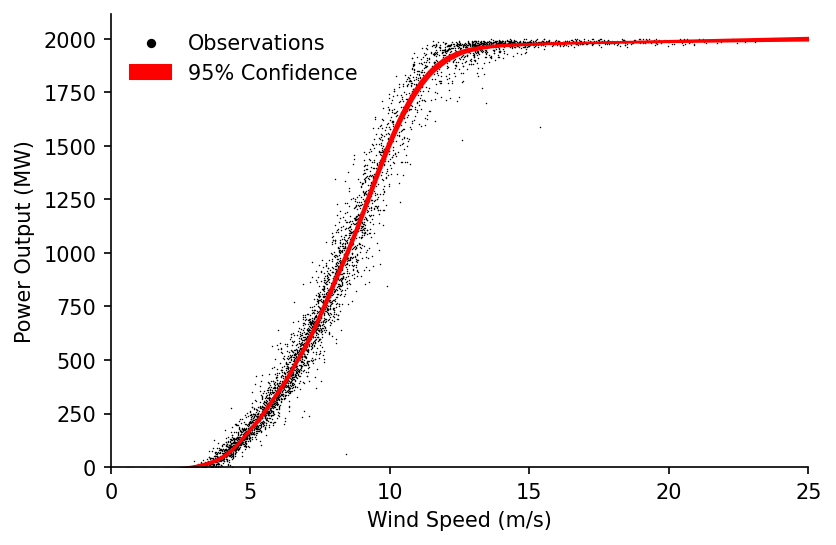

In [7]:
df_conf_intvl = lowess.get_confidence_interval(df_bootstrap, conf_pct=0.95)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(x, y, s=0.5, color='k', linewidth=0, alpha=1, label='Observations')
ax.fill_between(df_conf_intvl.index, df_conf_intvl['min'], df_conf_intvl['max'], color='r', alpha=1, label='95% Confidence')

eda.hide_spines(ax)
ax.legend(frameon=False)
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Power Output (MW)')
ax.set_xlim(0, 25)
ax.set_ylim(0)

lgnd = ax.legend(frameon=False) 
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[0].set_alpha(1)

<br>

We'll now visualise how the width of the confidence interval changes with wind speed. Interestingly the two troughs in the confidence interval width appear to correspond to the cut-in and start of the rated power wind speeds.

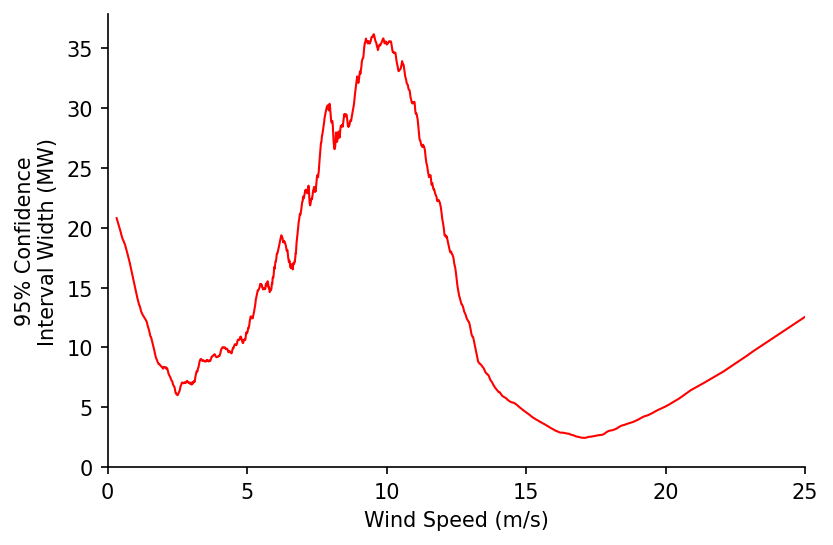

In [8]:
fig, ax = plt.subplots(dpi=150)

df_conf_intvl.diff(axis=1)['max'].plot(ax=ax, color='r', linewidth=1)

eda.hide_spines(ax)
ax.legend(frameon=False)
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('95% Confidence\nInterval Width (MW)')
ax.set_xlim(0, 25)
ax.set_ylim(0)
ax.get_legend().remove()

In [ ]:
# take the peak, then get the troughs on either side and print some info
# would be interesting to compare against these fits - https://www.hindawi.com/journals/jen/2016/8519785/tab1/

<br>

### Power Curve Cleaning

We'll start by loading the raw turbine wind speed and output data in

In [9]:
df_raw_pc = pd.read_csv('../data/lowess_examples/turbine_power_wind_speed_raw.csv')

df_raw_pc.head(3)

,UTC,active_power,wind_speed
0,30/09/2017 18:26,14.0,4.02
1,30/09/2017 18:56,14.0,4.02
2,30/09/2017 19:26,14.0,4.02


<br>

We'll then try and fit a LOWESS estimate for the power curve.

Wall time: 788 ms


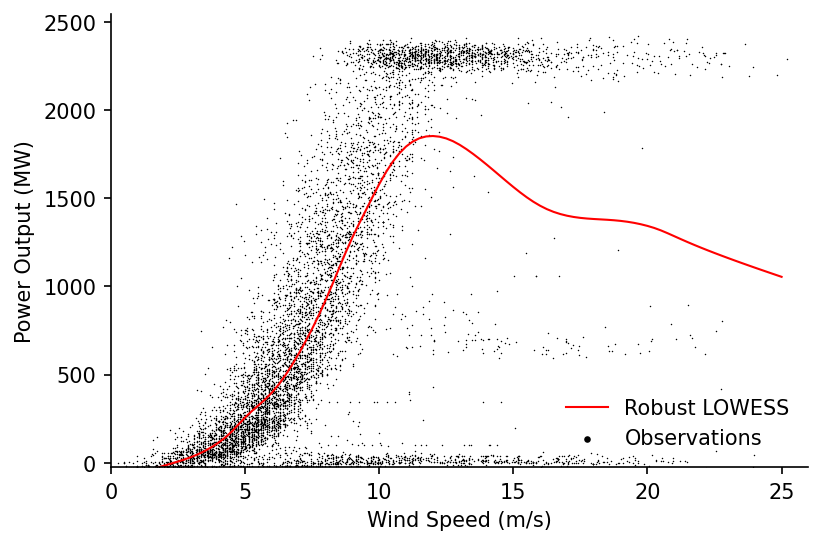

In [10]:
%%time

x = df_raw_pc['wind_speed'].values
y = df_raw_pc['active_power'].values

lowess_model = lowess.Lowess()
lowess_model.fit(x, y, frac=0.2, num_fits=100)

x_pred = np.linspace(0, 25, 101)
y_pred = lowess_model.predict(x_pred)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.plot(x_pred, y_pred, label='Robust LOWESS', color='r', linewidth=1)
ax.scatter(x, y, label='Observations', s=0.5, color='k', linewidth=0, alpha=1)

eda.hide_spines(ax)
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Power Output (MW)')
ax.set_xlim(0, 26)
ax.set_ylim(-25)

lgnd = ax.legend(frameon=False) 
lgnd.legendHandles[1]._sizes = [10]
lgnd.legendHandles[1].set_alpha(1)

<br>

Unfortunately the fit is thrown by the large number of occurences where the farm is under-powered or set to output 0, we want to remove these so that we can estimate the 'standard' power curve. We'll create a quantile LOWESS fit to see if that helps us understand the data any better.

In [11]:
# Estimating the quantiles
df_quantiles = lowess.quantile_model(x, y, frac=0.2, qs=np.linspace(0.025, 0.975, 41), num_fits=40)

# Cleaning names and sorting for plotting
df_quantiles.columns = [f'p{int(col*100)}' for col in df_quantiles.columns]
df_quantiles = df_quantiles[df_quantiles.columns[::-1]]

df_quantiles.head()

 [████████████████████████████████████████████████████████████] 41/41 [02:52<00:05, 4.20s/it]

,p97,p95,p92,p90,p88,p85,p83,p80,p78,p76,...,p23,p21,p19,p16,p14,p12,p9,p7,p4,p2
x,,,,,,,,,,,,,,,,,,,,,
0.25,-31.138943,-36.063656,-48.787512,-50.225155,-54.375248,-61.881759,-64.926254,-67.370517,-68.176035,-69.032379,...,-78.788130,-73.944711,-69.321976,-63.193786,-58.940816,-54.033732,-50.657819,-49.236591,-50.801038,-51.824759
0.33,-24.413665,-30.610793,-43.604414,-45.520463,-49.912984,-57.545203,-60.729165,-63.275040,-64.235407,-65.233799,...,-77.391861,-72.894614,-68.579404,-62.740178,-58.680432,-53.961285,-50.608743,-49.144467,-50.546003,-51.578860
0.41,-17.837829,-25.259973,-38.527423,-40.896936,-45.521473,-53.274741,-56.592850,-59.231692,-60.344065,-61.487147,...,-76.014021,-71.858512,-67.852225,-62.307253,-58.453376,-53.913426,-50.574612,-49.070218,-50.291389,-51.335279
0.49,-11.365853,-19.974835,-33.523677,-36.325733,-41.174405,-49.045466,-52.494676,-55.220039,-56.482108,-57.772743,...,-74.641947,-70.823212,-67.126139,-61.880349,-58.243593,-53.876901,-50.546571,-49.007175,-50.036505,-51.093366
0.57,-4.947601,-14.715394,-28.557015,-31.775095,-36.842879,-44.830165,-48.409769,-51.217707,-52.627811,-54.069014,...,-73.261943,-69.774489,-66.385850,-61.443766,-58.033785,-53.837458,-50.515147,-48.948112,-49.780591,-50.852403


<br>

Plotting these we can see an interesting relationship, where for many of the lower quantiles the estimate peaks then quickly drops to around 0. It is the area below and to the right of these peaks that we want to remove from our power curve estimate.

(0.0, 2557.302509884304)

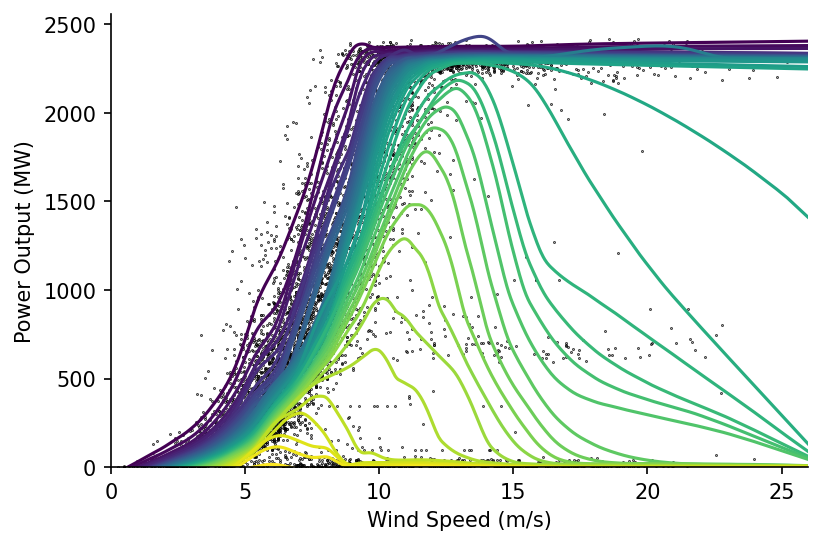

In [12]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(x, y, s=0.1, color='k', alpha=1)
df_quantiles.plot(cmap='viridis', legend=False, ax=ax)

eda.hide_spines(ax)
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Power Output (MW)')
ax.set_xlim(0, 26)
ax.set_ylim(0)

<br>

We'll first identify the ratio between the peak value and the final value (above speeds of 25 m/s). We'll then remove points after the peak where the ratio between their peak and final values exceeds a defined threshold (in our case 2).

N.b. there's probably a much nicer way to do this where the for loop isn't needed, this would be handy to implement as it would be good to have a vector containing all of the indexes that have been removed.

In [13]:
exceeded_quantiles = ((df_quantiles.max()/df_quantiles.iloc[-1].clip(0.1) > 2)
                      .replace(False, np.nan)
                      .dropna()
                      .index
                     )

s_maxs = df_quantiles[exceeded_quantiles].max()
s_idxmaxs = df_quantiles[exceeded_quantiles].idxmax()

cleaned_x = x
cleaned_y = y

for exceeded_quantile in exceeded_quantiles:
    min_x = s_idxmaxs[exceeded_quantile]
    max_y = s_maxs[exceeded_quantile]
    
    idxs_to_remove = (cleaned_x > min_x) & (cleaned_y < max_y)

    cleaned_x = cleaned_x[~idxs_to_remove]
    cleaned_y = cleaned_y[~idxs_to_remove]

<br>

Visualising the results we can clearly see that the unwanted periods have been removed

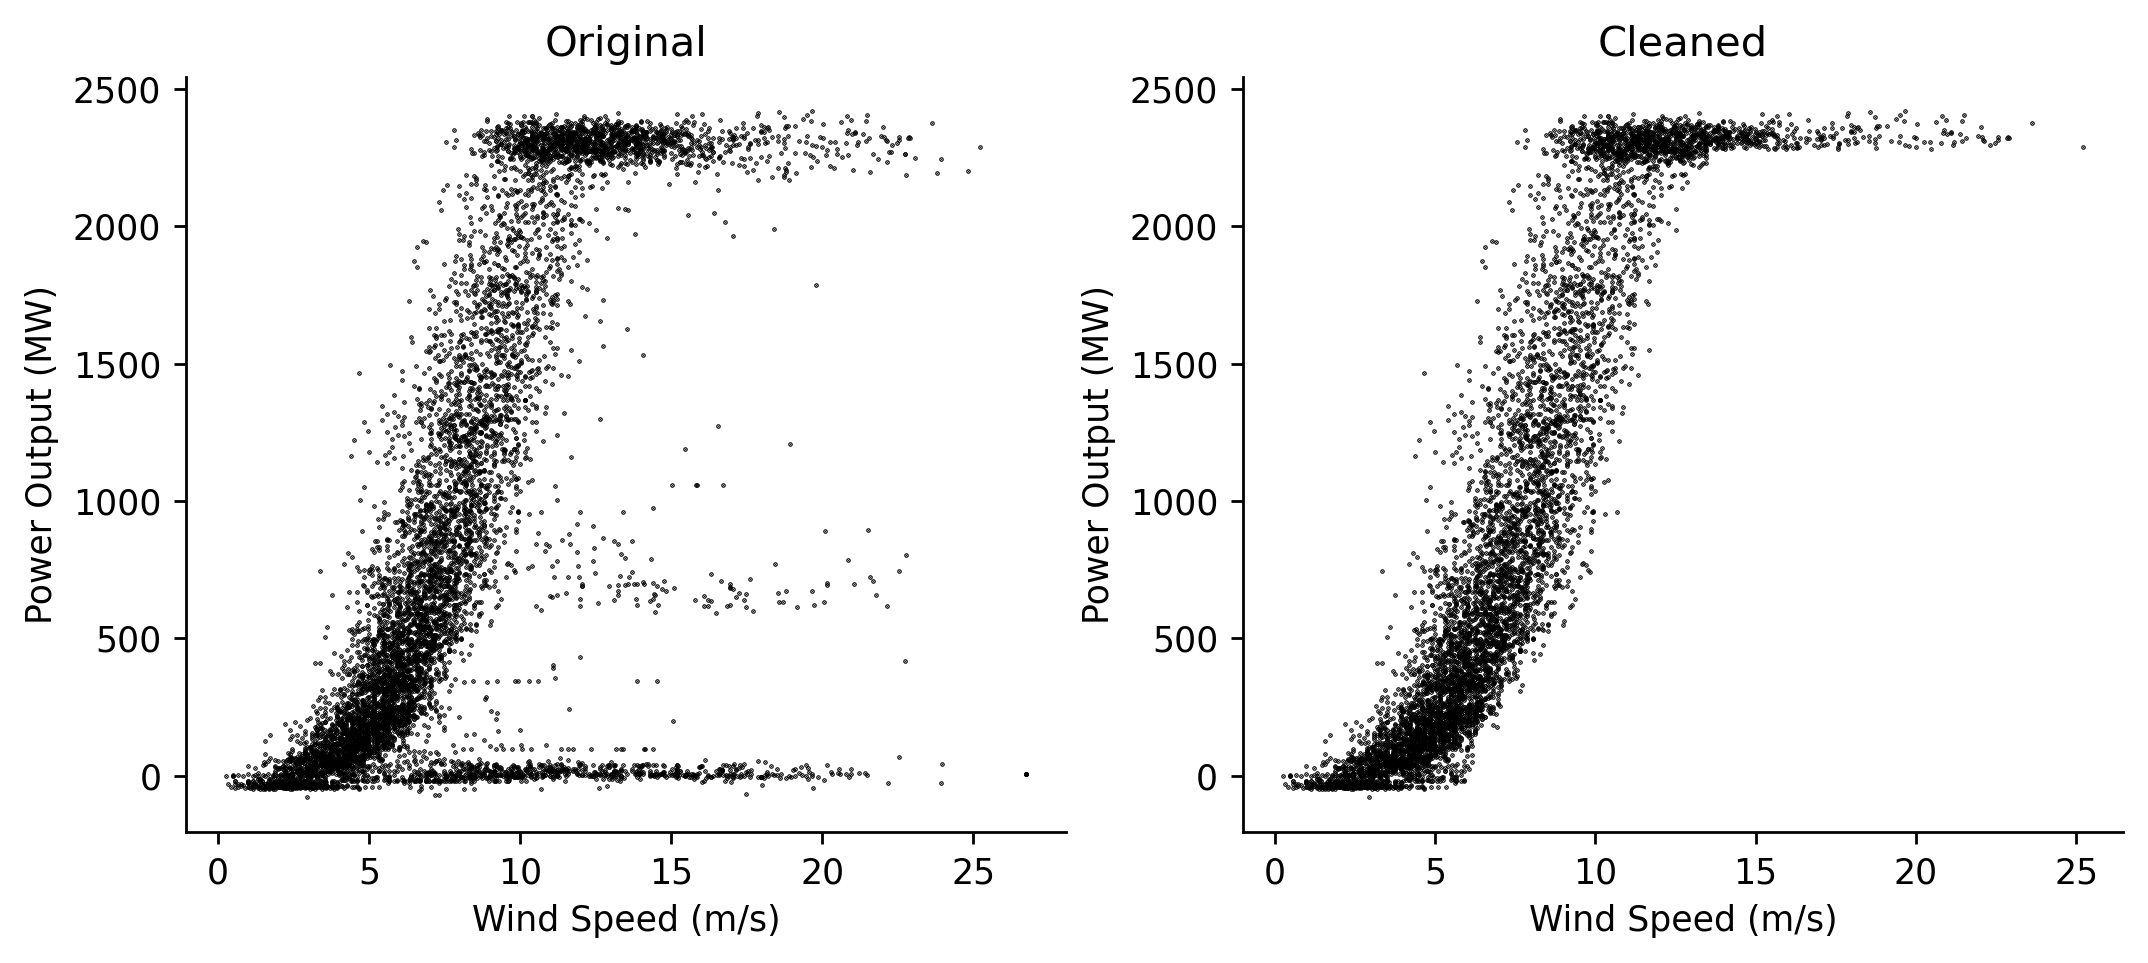

In [14]:
fig, axs = plt.subplots(dpi=250, ncols=2, figsize=(10, 4))

axs[0].scatter(x, y, s=0.1, color='k', alpha=1)
axs[1].scatter(cleaned_x, cleaned_y, s=0.1, color='k', alpha=1)

axs[0].set_title('Original')
axs[1].set_title('Cleaned')

for ax in axs:
    eda.hide_spines(ax)
    ax.set_xlabel('Wind Speed (m/s)')
    ax.set_ylabel('Power Output (MW)')

<br>

We're now ready to make our power curve LOWESS estimate again

Wall time: 728 ms


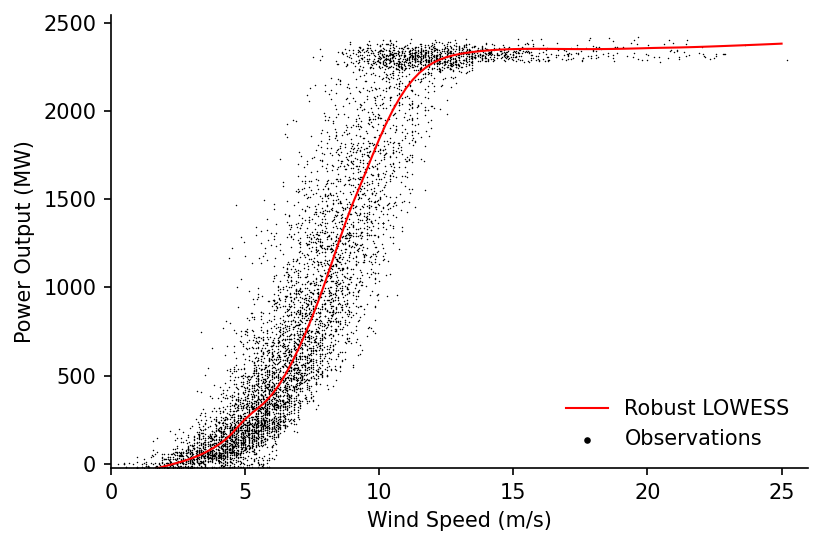

In [15]:
%%time

lowess_model = lowess.Lowess()
lowess_model.fit(cleaned_x, cleaned_y, frac=0.2, num_fits=100)

x_pred = np.linspace(0, 25, 101)
y_pred = lowess_model.predict(x_pred)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.plot(x_pred, y_pred, label='Robust LOWESS', color='r', linewidth=1)
ax.scatter(cleaned_x, cleaned_y, label='Observations', s=0.5, color='k', linewidth=0, alpha=1)

eda.hide_spines(ax)
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Power Output (MW)')
ax.set_xlim(0, 26)
ax.set_ylim(-25)

lgnd = ax.legend(frameon=False) 
lgnd.legendHandles[1]._sizes = [10]
lgnd.legendHandles[1].set_alpha(1)